<a href="https://colab.research.google.com/github/Osmayda/Modeling/blob/main/CopyCOPY_of_Healthcare_Stroke_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Healthcare Stroke Prediction**

#**Import Libraries**

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline as make_sampler_pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

## Models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline

## Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, confusion_matrix

## Set global scikit-learn configuration
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

# Filter ALL Warnings
import warnings
warnings.filterwarnings('ignore')

#**Useful Functions**

In [98]:
## Create a function to display the classification metrics of a model
def classification_metrics(model, X_test, y_test, label='Test Data',
                             figsize=(15,5), normalize='true',
                             cmap='Greens', thresh=.5):

    fig, axes = plt.subplots(1,2, figsize=figsize)

    ## Get the predictions
    y_proba = model.predict_proba(X_test)
    y_pred = [1 if x[1] > thresh else 0 for x in y_proba]

    ## Print classification report for the test data (and make it pretty!)
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)

    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,
                normalize=normalize, cmap=cmap,
                ax=axes[0])

    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1])
    plt.show()

In [99]:
## Define a function that takes in arguments and prints out a classification report and confusion matrix
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            cmap='Greens', normalize=None, classes=None,
                            figsize=(20,5), name='Classification Model',
                            average='binary', zero_division=0):

  # Gather model predictions
  train_preds = model.predict(X_train)
  test_preds = model.predict(X_test)

  # Display classification report and confusion matrices
  print('======Train Set Metrics======')
  print(classification_report(y_train, train_preds,
                                      zero_division=0,
                                      target_names=classes))

  print('======Test Set Metrics======')
  print(classification_report(y_test, test_preds,
                                      zero_division=0,
                                      target_names=classes))

  fig, axes = plt.subplots(ncols=2, figsize=figsize)

  ConfusionMatrixDisplay.from_predictions(y_train, train_preds, cmap=cmap,
                                display_labels=classes,
                                normalize=normalize, ax=axes[0])
  axes[0].set_title('Train Confusion Matrix')

  ConfusionMatrixDisplay.from_predictions(y_test, test_preds, cmap=cmap,
                              display_labels=classes,
                              normalize=normalize, ax=axes[1])
  axes[1].set_title('Test Confusion Matrix')
  plt.show()

  # If there are more than 2 classes and an average has not been set,
  # set average to 'macro'
  if average == 'binary' and y_train.nunique() > 2:
    average = 'macro'

  # Create a dataframe of scores to return
  scores = pd.DataFrame()

  # Training

  scores.loc[name, 'Train Accuracy'] = accuracy_score(y_train, train_preds)
  scores.loc[name, 'Train Recall'] = recall_score(y_train, train_preds,
                                                           average=average,
                                                       zero_division=zero_division)
  scores.loc[name, 'Train Precision'] = precision_score(y_train, train_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Train F1-Score'] = f1_score(y_train, train_preds,
                                                           average=average,
                                                     zero_division=zero_division)

  # Testing
  scores.loc[name, 'Test Accuracy'] = accuracy_score(y_test, test_preds)
  scores.loc[name, 'Test Recall'] = recall_score(y_test, test_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Test Precision'] = precision_score(y_test, test_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Test F1-Score'] = f1_score(y_test, test_preds,
                                                           average=average,
                                                     zero_division=zero_division)

  return scores

# **Load and inspect the data**

In [100]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
# Load the data
filename ="/content/drive/MyDrive/Coding Dojo/Stack 2 Intro to Machine Learning/Week 7/dataset/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(filename)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- The data loaded correctly.

In [102]:
# Display the number of rows and columns for the dataframe
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 5110 rows, and 12 columns.
The rows represent 5110 observations, and the columns represent 11 features and 1 target variable.


#**Clean the Data**

In [103]:
# Display the column names, count of non-null values, and their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### **Remove Unnecessary Columns**

- Removing id and work_type as they are not useful for predicting.

In [104]:
# Removing unnecessary columns
df.drop(columns = ['id', 'work_type'], inplace = True)
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status',
       'stroke'],
      dtype='object')

- Confirmed, the columns have been dropped.

### **Remove Unecessary Rows**

### **Duplicates**

In [105]:
# Display the number of duplicate rows in the dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


### **Missing Values**

In [106]:
# Display the total number of missing values
print(f'There are {df.isna().sum().sum()} missing values.')

There are 201 missing values.


In [107]:
# Check for missing values. You should produce an output that shows the number of missing values for each feature.
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [108]:
# missing values as percentage
round((df.isna().sum() / len(df)) * 100, 2)

gender               0.00
age                  0.00
hypertension         0.00
heart_disease        0.00
ever_married         0.00
Residence_type       0.00
avg_glucose_level    0.00
bmi                  3.93
smoking_status       0.00
stroke               0.00
dtype: float64

In [109]:
# Check for and address values in numerical columns.
df.describe(include='number')

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- The min for age is .08 which appears to be an impossible number.

In [110]:
# age of 0.08
df[df['age'] == 0.08]

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1614,Female,0.08,0,0,No,Urban,139.67,14.1,Unknown,0
3295,Male,0.08,0,0,No,Rural,70.33,16.9,Unknown,0


- Only 2 samples, correctly attributed as 'children'.

In [111]:
df['bmi'].value_counts()

28.7    41
28.4    38
26.7    37
27.6    37
26.1    37
        ..
48.7     1
49.2     1
51.0     1
49.4     1
14.9     1
Name: bmi, Length: 418, dtype: int64

In [112]:
df['bmi'].value_counts(normalize=True)

28.7    0.008352
28.4    0.007741
26.7    0.007537
27.6    0.007537
26.1    0.007537
          ...   
48.7    0.000204
49.2    0.000204
51.0    0.000204
49.4    0.000204
14.9    0.000204
Name: bmi, Length: 418, dtype: float64

In [113]:
# We only want to keep data points that happened more than 3%
values = [14.9, 55.1, 57.3, 56.0, 13.4, 51.8, 57.7, 44.4, 54.0, 56.1, 97.6, 53.9, 11.5, 49.4, 49.2, 48.7, 66.8, 53.5, 54.8, 55.2, 48.2, 64.8, 46.6, 60.2, 51.0, 51.5, 71.9, 40.6, 12.0, 44.1, 57.5, 54.2, 52.3, 12.3, 78.0, 48.4, 50.5, 16.5, 50.8, 50.4, 11.3, 61.6]

df = df[df['bmi'].isin(values) == False]

In [114]:
df['bmi'].value_counts(normalize=True)

28.7    0.008429
28.4    0.007812
26.7    0.007607
26.1    0.007607
27.6    0.007607
          ...   
52.5    0.000206
13.2    0.000206
52.9    0.000206
49.9    0.000206
54.1    0.000206
Name: bmi, Length: 376, dtype: float64

In [115]:
df['age'].value_counts()

78.00    102
57.00     94
51.00     86
52.00     86
54.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: age, Length: 104, dtype: int64

In [116]:
df['age'].value_counts(normalize=True)

78.00    0.020138
57.00    0.018559
51.00    0.016979
52.00    0.016979
54.00    0.016979
           ...   
1.40     0.000592
0.48     0.000592
0.16     0.000592
0.40     0.000395
0.08     0.000395
Name: age, Length: 104, dtype: float64

In [117]:
# We only want to keep data points that happened more than 3%
values = [1.80, 1.64, 1.88, 1.24, 1.08, 1.32, 1.48, 1.72, 0.32, 0.56, 0.72, 0.88, 0.24, 1.00, 1.56, 1.16, 0.64, 0.80, 1.40, 0.48, 0.16, 0.40, 0.08]

df = df[df['age'].isin(values) == False]

In [118]:
df['age'].value_counts()

78.0    102
57.0     94
52.0     86
51.0     86
54.0     86
       ... 
10.0     35
11.0     35
4.0      33
7.0      32
6.0      24
Name: age, Length: 81, dtype: int64

In [119]:
# Check for and address values in categorical columns.
df.describe(include='object')

,gender,ever_married,Residence_type,smoking_status
count,4948,4948,4948,4948
unique,3,2,2,4
top,Female,Yes,Urban,never smoked
freq,2908,3324,2517,1873


## **Insconsistencies in 'object' categories**

In [120]:
# Check for discrepancies in categorical data
for i in df.dtypes[df.dtypes == 'object'].index:
  print(f'{i} ---')
  print(df[i].unique())
  print('')

gender ---
['Male' 'Female' 'Other']

ever_married ---
['Yes' 'No']

Residence_type ---
['Urban' 'Rural']

smoking_status ---
['formerly smoked' 'never smoked' 'smokes' 'Unknown']



In [121]:
for i in df.dtypes[df.dtypes == 'object'].index:
  print(f'{i} ---')
  print(df[i].value_counts())
  print('')

gender ---
Female    2908
Male      2039
Other        1
Name: gender, dtype: int64

ever_married ---
Yes    3324
No     1624
Name: ever_married, dtype: int64

Residence_type ---
Urban    2517
Rural    2431
Name: Residence_type, dtype: int64

smoking_status ---
never smoked       1873
Unknown            1411
formerly smoked     880
smokes              784
Name: smoking_status, dtype: int64



In [122]:
# Replacing F with female and M with male then checking to make sure it worked.
df['gender'].replace({'Other': 'Female'}, inplace=True)
df['ever_married'].replace({'Yes':1, 'No':0}, inplace=True)
df['Residence_type'].replace({'Urban':1, 'Rural':0}, inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1,1,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,1,0,202.21,NaN,never smoked,1
2,Male,80.0,0,1,1,0,105.92,32.5,never smoked,1
3,Female,49.0,0,0,1,1,171.23,34.4,smokes,1
4,Female,79.0,1,0,1,0,174.12,24.0,never smoked,1


In [123]:
# Replace boolean values with 0s and 1s
df['gender'].replace({'Female':1, 'Male':0}, inplace=True)

# Rename 'gender' to 'isfemale' for clarity
df.rename(columns={'gender':'isfemale'}, inplace=True)

df[['isfemale']].value_counts()

isfemale
1           2909
0           2039
dtype: int64

In [124]:
# Check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4948 entries, 0 to 5109
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   isfemale           4948 non-null   int64  
 1   age                4948 non-null   float64
 2   hypertension       4948 non-null   int64  
 3   heart_disease      4948 non-null   int64  
 4   ever_married       4948 non-null   int64  
 5   Residence_type     4948 non-null   int64  
 6   avg_glucose_level  4948 non-null   float64
 7   bmi                4753 non-null   float64
 8   smoking_status     4948 non-null   object 
 9   stroke             4948 non-null   int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 425.2+ KB


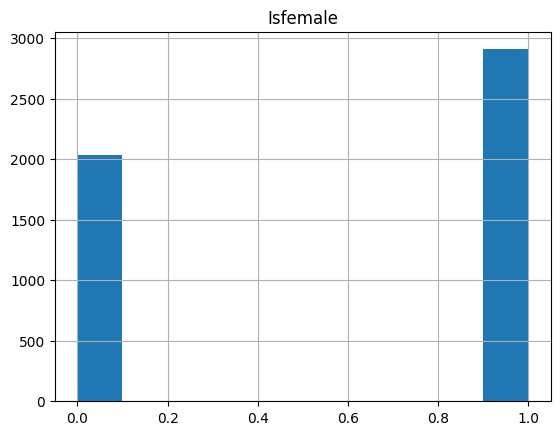

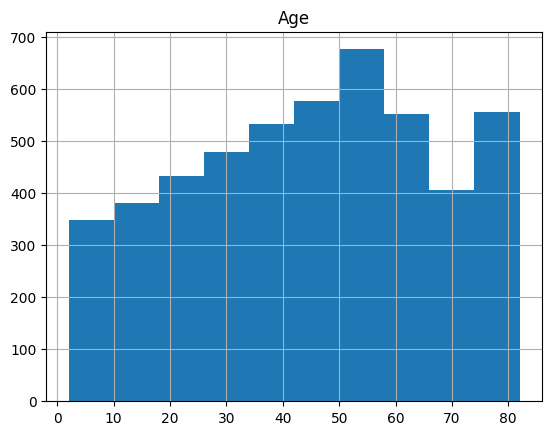

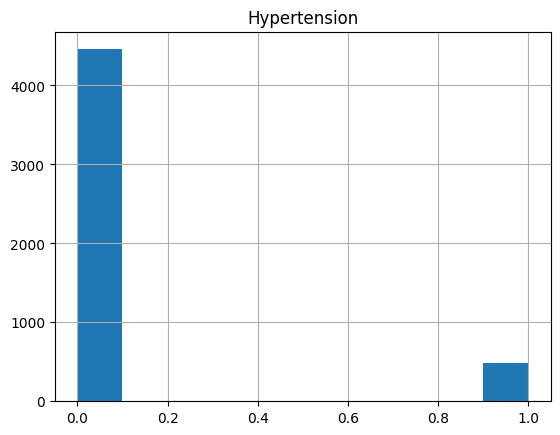

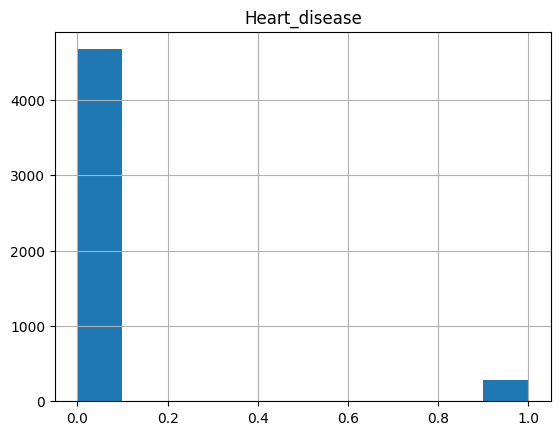

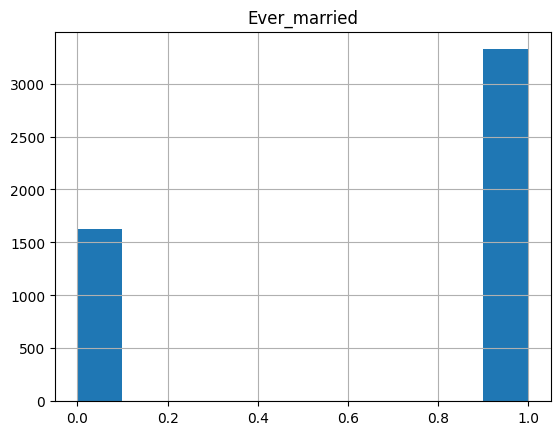

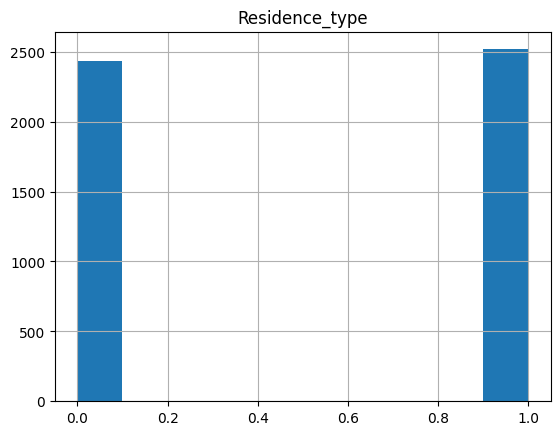

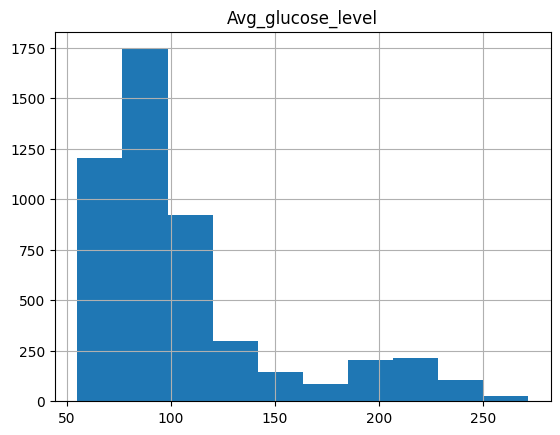

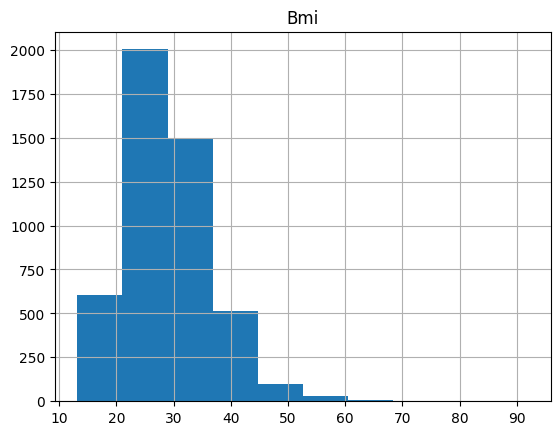

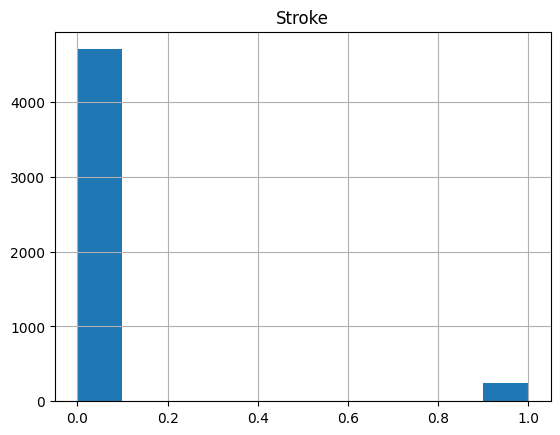

In [125]:
# Explore numeric distributions

for col in df.select_dtypes('number'):
  df[col].hist()
  plt.title(col.capitalize())

  plt.show()

<Axes: >

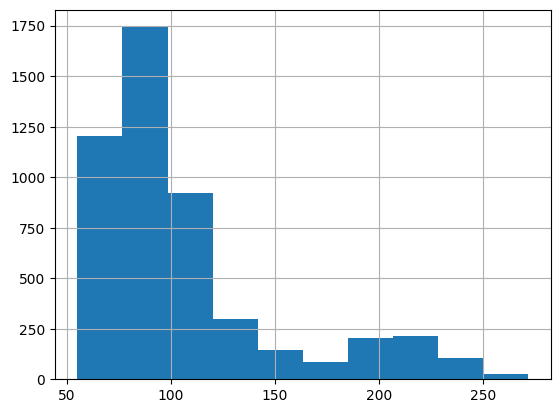

In [126]:
# Transfrom to normalize feature
df['avg_glucose_level'].hist()

<Axes: >

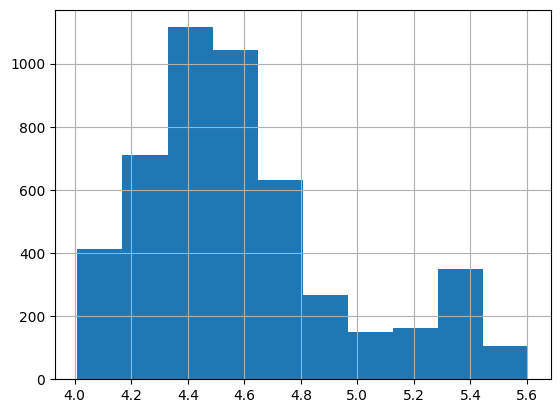

In [127]:
# log transform avg_glucose_level

df['avg_glucose_level'] = np.log(df['avg_glucose_level'])

df['avg_glucose_level'].hist()

<Axes: >

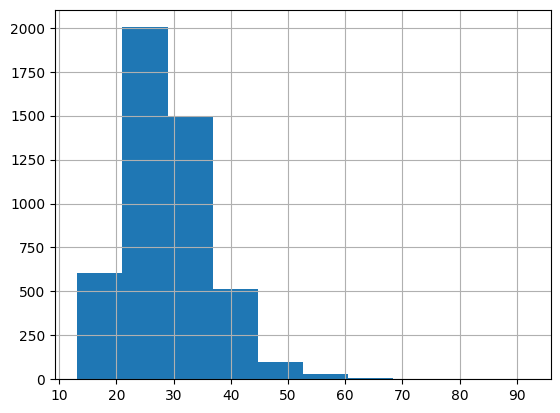

In [128]:
df['bmi'].hist()

<Axes: >

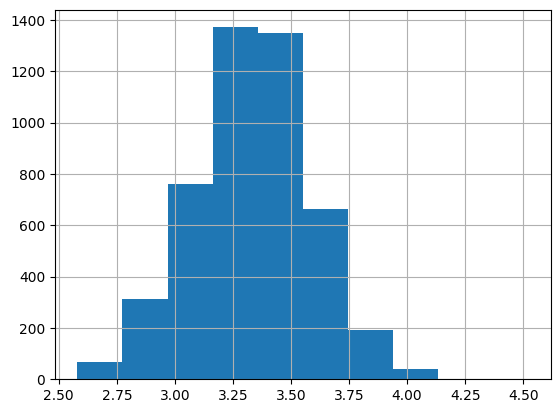

In [129]:
# log transform bmi

df['bmi'] = np.log(df['bmi'])

df['bmi'].hist()

#**Exploratory Visualizations**

##**Heatmap of Stroke Correlation**

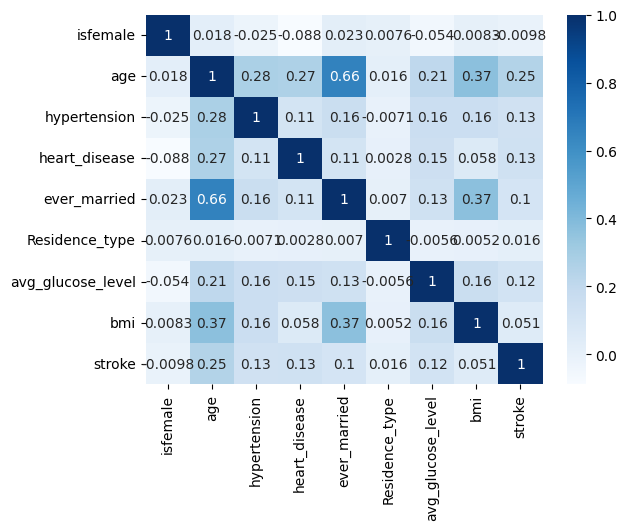

In [130]:
corr = df.corr()
sns.heatmap(data=corr, cmap='Blues', annot=True);

- The most correlated feature with the target (stroke) is age.
- Hypertension and heart disease and avg_glucose level also have a correlation to the target (stroke).

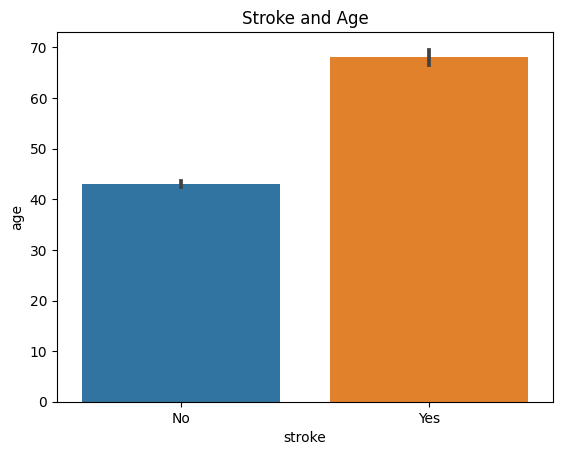

In [131]:
# barplot visual
fig, ax = plt.subplots()

sns.barplot(data=df, x='stroke', y='age')
ax.set_title('Stroke and Age')
ax.set_xlabel('stroke')
ax.set_ylabel('age')
plt.xticks(range(0,2), ['No', 'Yes']);

- People over 40 are more prone to having a stroke.

#**Multivariate (Multiple Variables) Exploratory Visualizations**

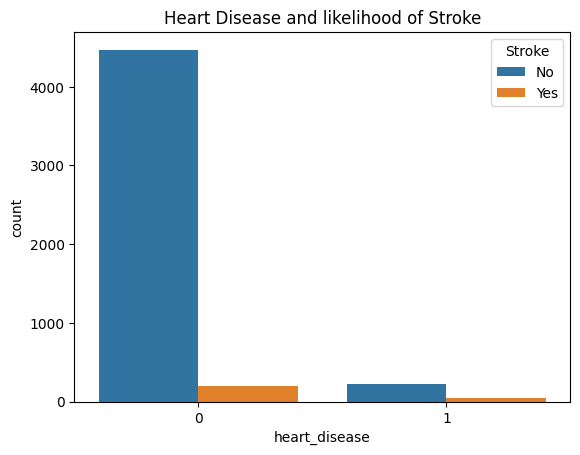

In [200]:
fig, ax = plt.subplots()

ax = sns.countplot(data=df, x='heart_disease', hue='stroke')
ax.set_title('Heart Disease and likelihood of Stroke')
ax.set_xlabel('heart_disease')
plt.legend(title='Stroke', labels=['No', 'Yes']);

0 if the patient doesn't have any heart disease

1 if the patient has a heart disease

- patients with no heart disease are more likely to have a stroke. This could be because patients with no heart disease probably do not check their heart health as frequently. Patients with heart disease are probably under medications and can it be assumed that they are under a doctor's care that would keep them better informed of how to prevent strokes.

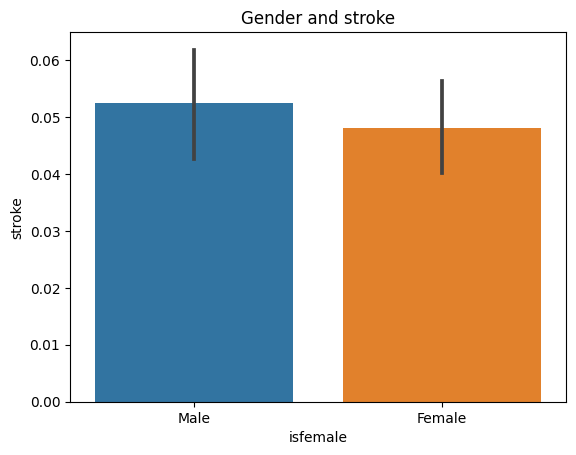

In [133]:
## Define a MatplotLib ax object using sns.barplot()
ax = sns.barplot(x= 'isfemale', y = 'stroke', data = df)

## Set the Title
ax.set_title('Gender and stroke')
ax.set_xticks(range(0, 2), ['Male', 'Female']);

Female:1, Male:0

- Men are more likely to have stroke than women.

#**Modeling**

In [134]:
## Create a copy of the dataset for Modeling
ml_df = df.copy()

## **Check Class Balance**

In [135]:
# Check how many samples of each class are present
ml_df['stroke'].value_counts(normalize=False)

0    4701
1     247
Name: stroke, dtype: int64

In [136]:
# Check how many samples of each class are present
ml_df['stroke'].value_counts(normalize=True)

0    0.950081
1    0.049919
Name: stroke, dtype: float64

- The data is unbalanced

In [137]:
 #1 if the patient had a stroke or 0 if not
 ## Create a list of the target labels
#labels = ['Stay','Leave']

## **Split the Data**

In [138]:
## Define features (X) and target (y)
target = 'stroke'
X = ml_df.drop(columns = [target]).copy()
y = ml_df[target].copy()

In [139]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [140]:
# Check how many samples of each class are present for train
y_train.value_counts(normalize=True)

0    0.950043
1    0.049957
Name: stroke, dtype: float64

In [141]:
## Check how many samples of each class are present for test
y_test.value_counts(normalize=True)

0    0.950168
1    0.049832
Name: stroke, dtype: float64

# **Custom Function**

In [142]:
## Create a function to display the classification metrics of a model
def probability_report_matrix(model, X_test, y_test, label='Probability Test Data',
                             figsize=(15,5), normalize=None,
                             cmap='Greens', thresh=.5):

    fig, axes = plt.subplots(1,2, figsize=figsize)

    ## Get the predictions
    y_proba = model.predict_proba(X_test)
    y_pred = [1 if x[1] > thresh else 0 for x in y_proba]

    ## Print classification report for the test data (and make it pretty!)
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)

    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,
                normalize=normalize, cmap=cmap,
                ax=axes[0])

    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1])

    plt.show()

# **Preprocessing**

In [143]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

mean_imputer = SimpleImputer(strategy='mean')
missing_imputer = SimpleImputer(strategy='constant', fill_value='missing')

num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_include='object')


num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(missing_imputer, ohe)

processor = make_column_transformer((num_pipe, num_cols),
                                    (cat_pipe, cat_cols))

#**Models**

# **Logistic Regression Model**

In [144]:
## Create an instance of the model
## Default class_weight=None
log_reg = LogisticRegression(max_iter=1000, class_weight=None)
## Create a model pipeline
log_reg_pipe = make_pipeline(processor, log_reg)
## Fit the model
log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f17e0>)])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3290
           1       0.00      0.00      0.00       173

    accuracy                           0.95      3463
   macro avg       0.48      0.50      0.49      3463
weighted avg       0.90      0.95      0.93      3463

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1411
           1       0.00      0.00      0.00        74

    accuracy                           0.95      1485
   macro avg       0.48      0.50      0.49      1485
weighted avg       0.90      0.95      0.93      1485



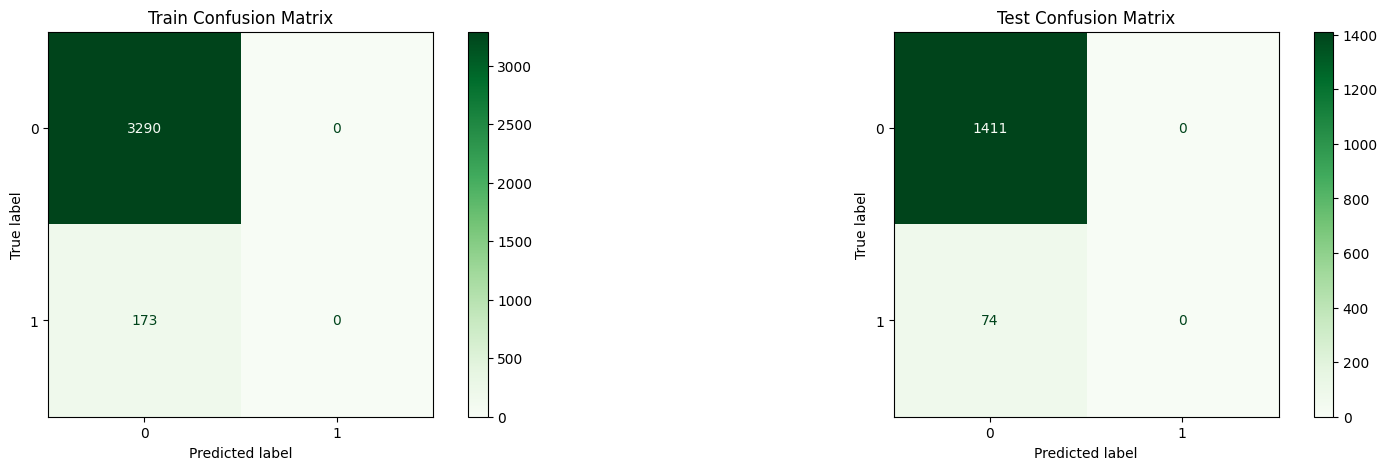

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
log_reg,0.950043,0.0,0.0,0.0,0.950168,0.0,0.0,0.0


In [145]:
## Display the Model's metrics
score = evaluate_classification(log_reg_pipe, X_train, y_train, X_test, y_test, name='log_reg')
score

- This model is 95% accurate.
- The recall is 0.
- The precision is also 0.
- Model did not predict patients that had a stroke. True positive is 0.



# **Balanced Class Weight**

In [146]:
## Create an instance of the model
## Default class_weight='balanced'
log_reg_bal = LogisticRegression(max_iter=1000, class_weight='balanced')
## Create a model pipeline
log_reg_bal_pipe = make_pipeline(processor, log_reg_bal)
## Fit the model
log_reg_bal_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f17e0>)])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      3290
           1       0.14      0.84      0.24       173

    accuracy                           0.74      3463
   macro avg       0.57      0.79      0.54      3463
weighted avg       0.95      0.74      0.81      3463

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1411
           1       0.13      0.78      0.22        74

    accuracy                           0.73      1485
   macro avg       0.56      0.76      0.53      1485
weighted avg       0.94      0.73      0.81      1485



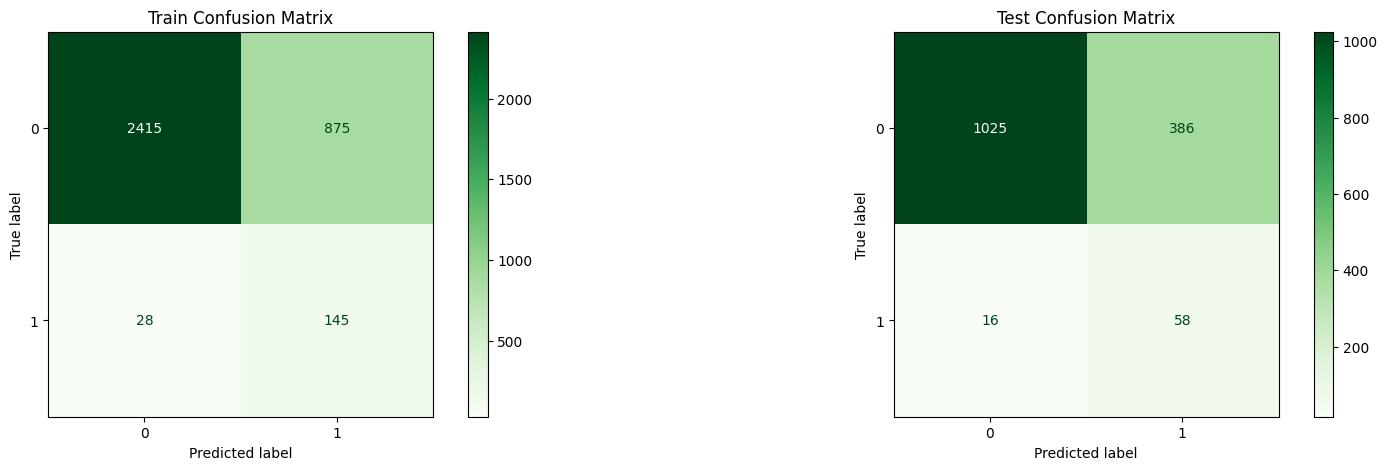

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
log_reg,0.950043,0.00000,0.000000,0.000000,0.950168,0.000000,0.000000,0.000000
log_reg class weights,0.739243,0.83815,0.142157,0.243085,0.729293,0.783784,0.130631,0.223938


In [147]:
## Display the Model's metrics
log_reg_balanced_score = evaluate_classification(log_reg_bal_pipe, X_train, y_train, X_test, y_test,
                        name='log_reg class weights')

score = pd.concat([score, log_reg_balanced_score])
score

- This model is 75% accurate.
- The model shows 16 false negative. The model did not predict 16 people with strokes. As strokes can be lethal, it is important to minimize this number.

## **Undersampling**

In [148]:
## Import RandomUnderSampler from imblearn
from imblearn.pipeline import make_pipeline as resample_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [149]:
## Create the under sampling object
under_sampler = RandomUnderSampler()

======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      3290
           1       0.14      0.82      0.24       173

    accuracy                           0.74      3463
   macro avg       0.56      0.78      0.54      3463
weighted avg       0.94      0.74      0.81      3463

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1411
           1       0.13      0.77      0.22        74

    accuracy                           0.73      1485
   macro avg       0.56      0.75      0.53      1485
weighted avg       0.94      0.73      0.81      1485



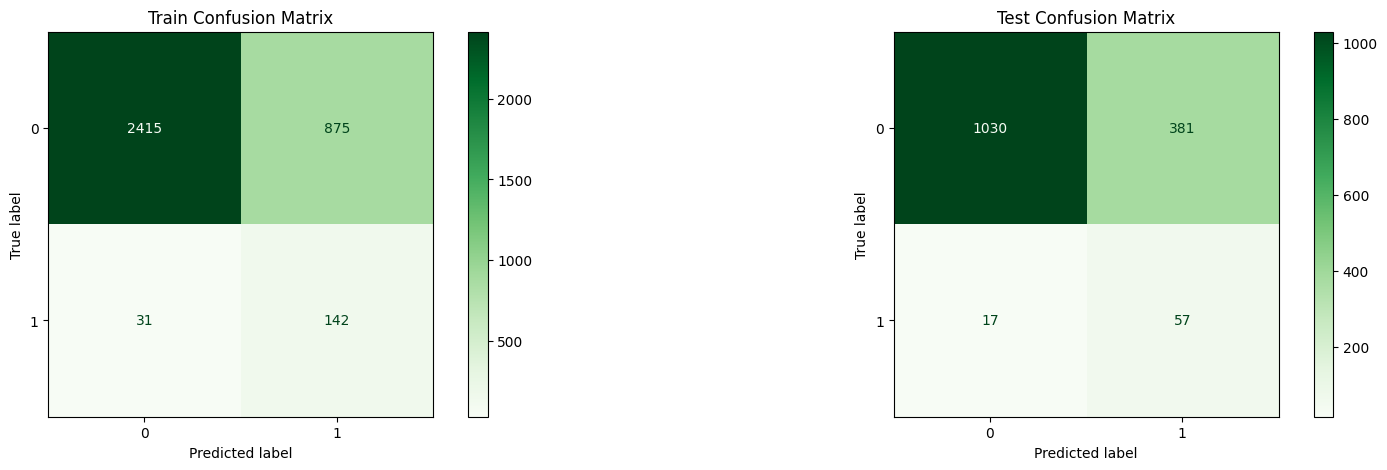

In [150]:
## Create a model pipeline with an UnderSampler in the pipeline
under_pipe = resample_pipeline(processor, under_sampler, log_reg)
under_pipe.fit(X_train, y_train)

## Evaluate model trained on undersampled data
underscores = evaluate_classification(under_pipe, X_train, y_train, X_test, y_test,
                                      name='undersampled LogReg')

In [151]:
score = pd.concat([score, underscores])
score

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
log_reg,0.950043,0.000000,0.000000,0.000000,0.950168,0.000000,0.000000,0.000000
log_reg class weights,0.739243,0.838150,0.142157,0.243085,0.729293,0.783784,0.130631,0.223938
undersampled LogReg,0.738377,0.820809,0.139626,0.238655,0.731987,0.770270,0.130137,0.222656


- This model is 72% accurate.
- The False negative count went up. It is worst at predicting patients who had a stroke.

## **Oversampling**

In [152]:
## Import RandomUnderSampler from imblearn
from imblearn.over_sampling import RandomOverSampler

In [153]:
## Create the under sampling object

over_sampler = RandomOverSampler()

In [154]:
## Display the value counts for y_train
display(y_train.value_counts())


## undersample the y_train
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

## Display the value counts for y_train_undersampled
display(y_train_over.value_counts())

0    3290
1     173
Name: stroke, dtype: int64

0    3290
1    3290
Name: stroke, dtype: int64

======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      3290
           1       0.15      0.83      0.25       173

    accuracy                           0.75      3463
   macro avg       0.57      0.79      0.55      3463
weighted avg       0.95      0.75      0.82      3463

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1411
           1       0.13      0.78      0.23        74

    accuracy                           0.73      1485
   macro avg       0.56      0.76      0.53      1485
weighted avg       0.94      0.73      0.81      1485



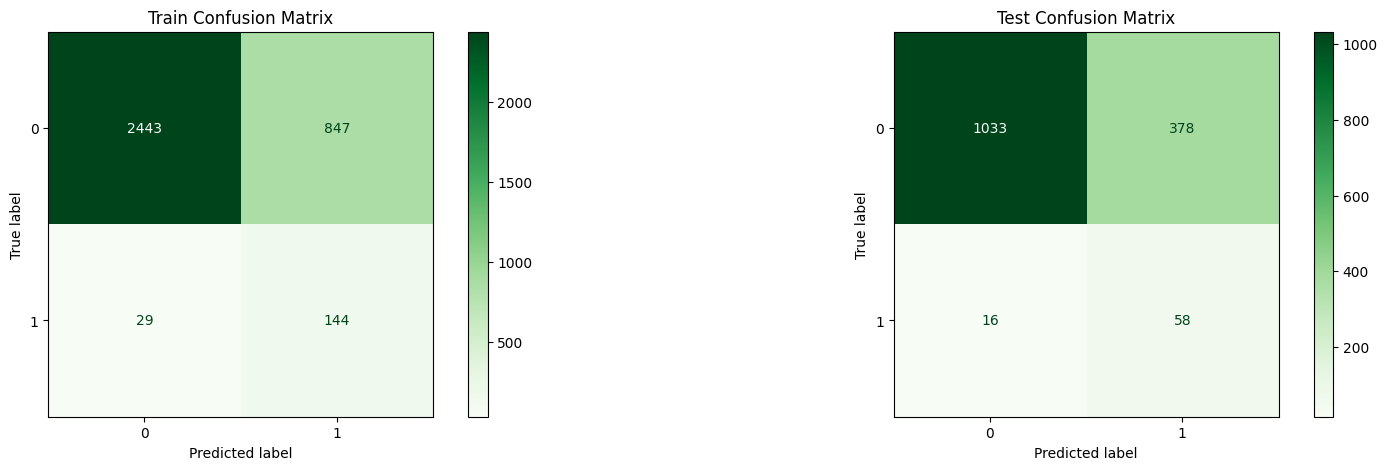

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
log_reg,0.950043,0.000000,0.000000,0.000000,0.950168,0.000000,0.000000,0.000000
log_reg class weights,0.739243,0.838150,0.142157,0.243085,0.729293,0.783784,0.130631,0.223938
undersampled LogReg,0.738377,0.820809,0.139626,0.238655,0.731987,0.770270,0.130137,0.222656
oversampled log_reg,0.747040,0.832370,0.145308,0.247423,0.734680,0.783784,0.133028,0.227451


In [155]:
## Create a model pipeline with an oversampler in the pipeline
over_pipe = resample_pipeline(processor, over_sampler, log_reg)


## Fit the model
over_pipe.fit(X_train, y_train)

## Evaluate the model
over_score = evaluate_classification(over_pipe, X_train, y_train, X_test, y_test,
                                     name='oversampled log_reg')
score = pd.concat([score, over_score])
score

- This model is slightly more accurate than the prior model.
- The false negative count went down again which is what we want for this business problem.

#**KNN Model**

In [156]:
# Create an instance of the model
knn = KNeighborsClassifier()
# Create a model pipeline
knn_pipe = make_pipeline(processor, knn)
## Fit the model
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f17e0>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: KNN Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3290
           1       0.60      0.05      0.10       173

    accuracy                           0.95      3463
   macro avg       0.78      0.53      0.54      3463
weighted avg       0.93      0.95      0.93      3463



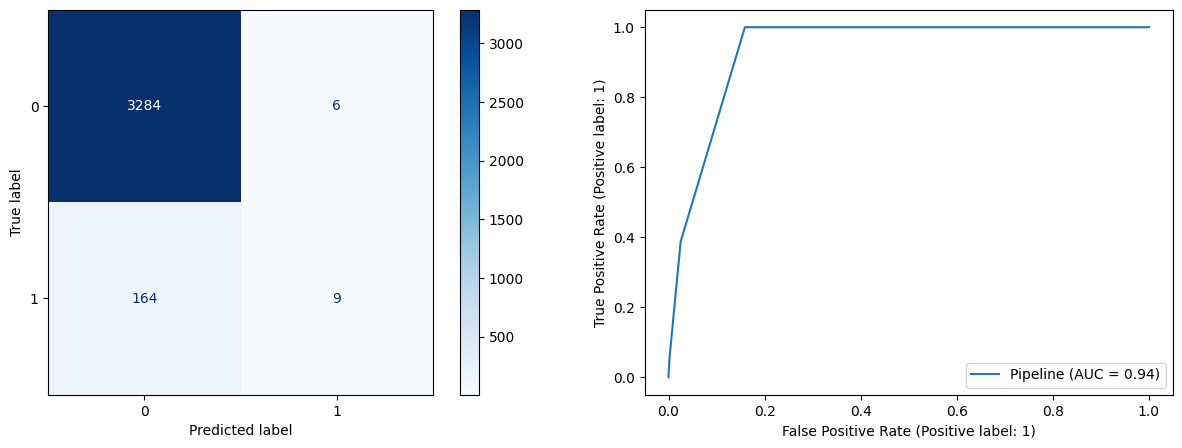

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: KNN Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1411
           1       0.17      0.01      0.03        74

    accuracy                           0.95      1485
   macro avg       0.56      0.50      0.50      1485
weighted avg       0.91      0.95      0.93      1485



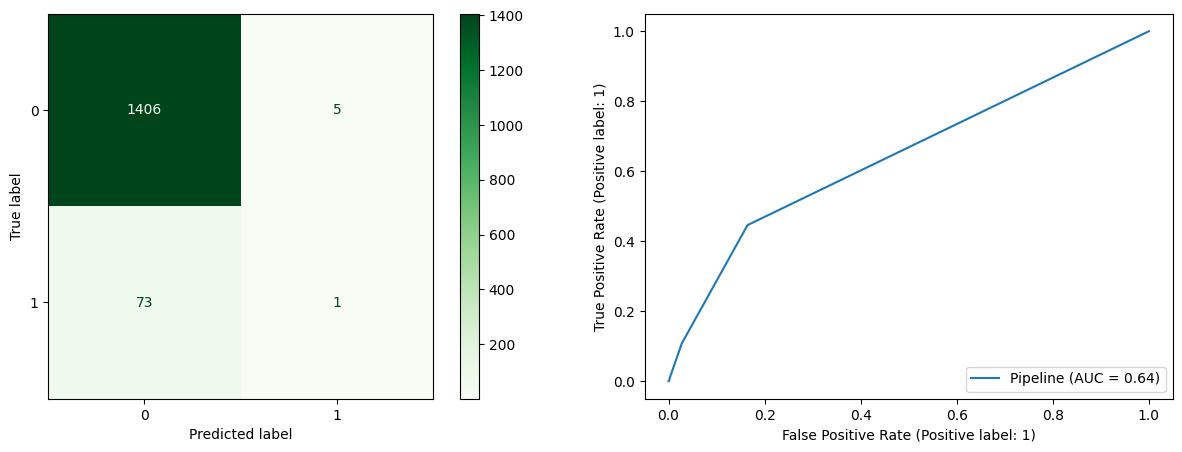

In [157]:
probability_report_matrix(knn_pipe, X_train, y_train, label='KNN Train Data',
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(knn_pipe, X_test, y_test, label='KNN Test Data',
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

- The accuracy for this model is 95%. It has a high count of false negative. This number needs to be reduced.

##**KNN Tuning**

In [158]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                               

In [159]:
param_grid = {'kneighborsclassifier__n_neighbors': range(1,10),
              'kneighborsclassifier__p': range(1,5),
              'kneighborsclassifier__weights': ['distance','uniform']}

In [160]:
knn_pipe_gs = GridSearchCV(knn_pipe, param_grid, scoring='f1')

knn_pipe_gs.fit(X_train, y_train)
print('Best KNN Parameters:')
print(knn_pipe_gs.best_params_)
best_pipe = knn_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_pipe.score(X_test, y_test)}')

Best KNN Parameters:
{'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'distance'}
Accuracy of best KNN model is: 0.9259259259259259


## **Tuned KNN**

In [161]:
tuned_knn = KNeighborsClassifier(n_neighbors=1, p=3, weights='distance')
tuned_knn_pipe = make_pipeline(processor, tuned_knn)
tuned_knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f17e0>)])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=1, p=3, weights='distance'))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned KNN Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3290
           1       1.00      1.00      1.00       173

    accuracy                           1.00      3463
   macro avg       1.00      1.00      1.00      3463
weighted avg       1.00      1.00      1.00      3463



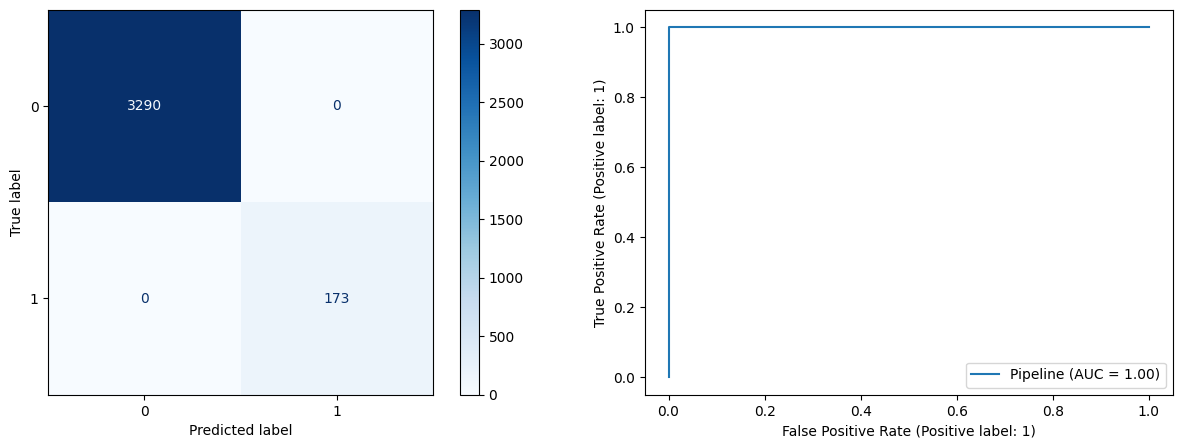

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned KNN Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1411
           1       0.17      0.14      0.15        74

    accuracy                           0.92      1485
   macro avg       0.56      0.55      0.55      1485
weighted avg       0.92      0.92      0.92      1485



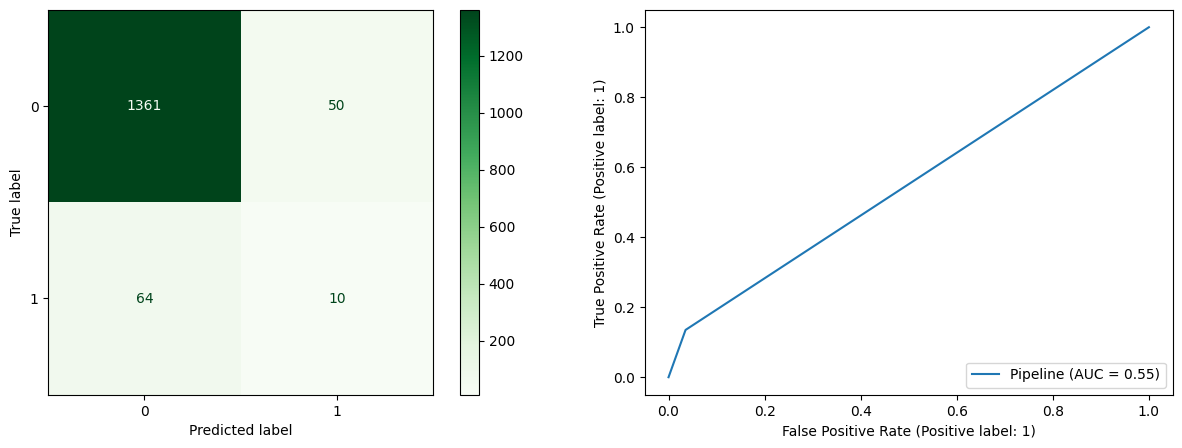

In [162]:
probability_report_matrix(tuned_knn_pipe, X_train, y_train, label='Tuned KNN Train Data',
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(tuned_knn_pipe, X_test, y_test, label='Tuned KNN Test Data',
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.3)

- The model did better at reducing the false negative.
 - False positive went up as well and accuracy is 92%.

# **Random Forest Model**

In [163]:
ranforest = RandomForestClassifier(random_state=42)

ranforest_pipe = make_pipeline(processor, ranforest)
ranforest_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f17e0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Random Forest Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3290
           1       1.00      1.00      1.00       173

    accuracy                           1.00      3463
   macro avg       1.00      1.00      1.00      3463
weighted avg       1.00      1.00      1.00      3463



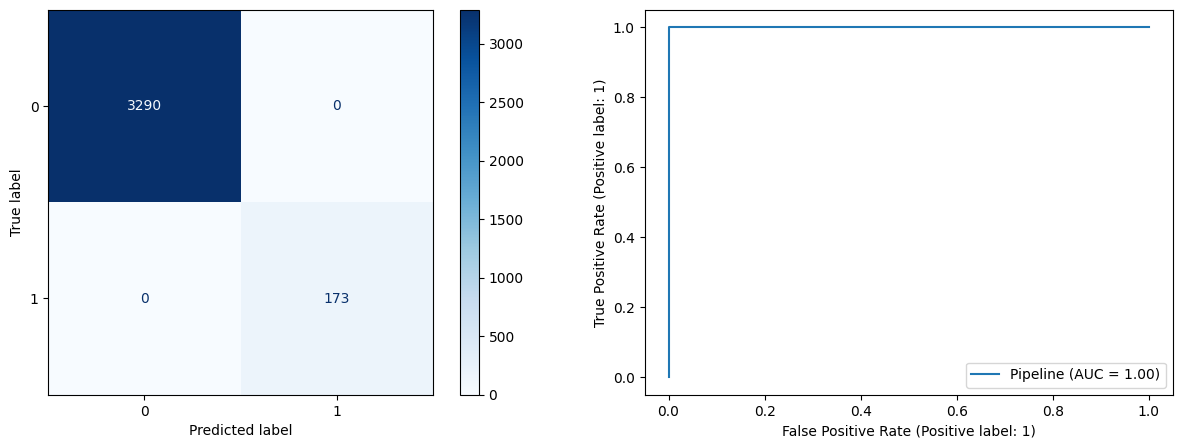

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Random Forest Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1411
           1       0.50      0.03      0.05        74

    accuracy                           0.95      1485
   macro avg       0.73      0.51      0.51      1485
weighted avg       0.93      0.95      0.93      1485



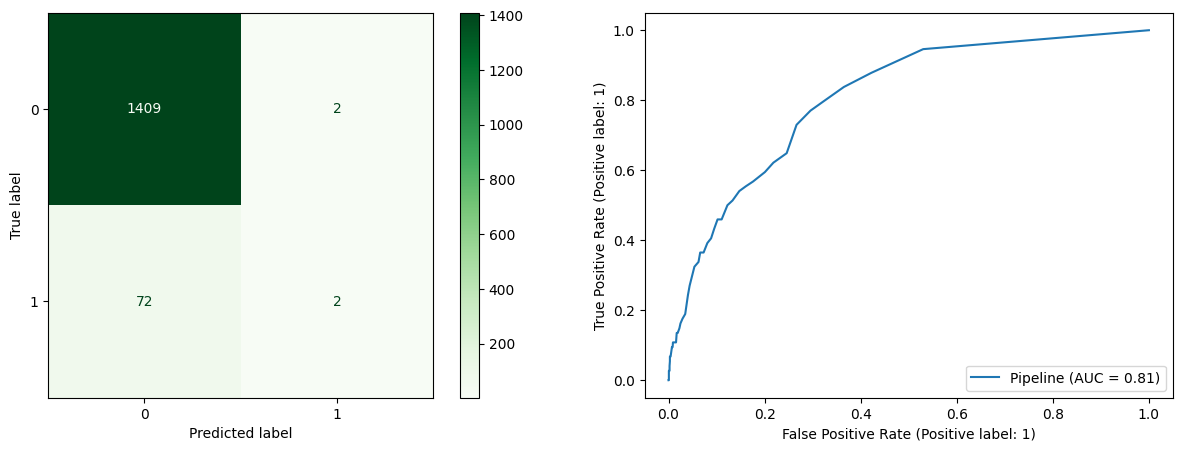

In [164]:
probability_report_matrix(ranforest_pipe, X_train, y_train, label='Random Forest Train Data',
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(ranforest_pipe, X_test, y_test, label='Random Forest Test Data',
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

## **Random Forest Tuning**

In [165]:
ranforest_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                               

In [166]:
ranforest_params = {'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample'],
            'randomforestclassifier__max_depth': [None, 5, 10, 15],
            'randomforestclassifier__n_estimators': [10, 30, 50, 100],
            'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']}

In [167]:
ranforest_pipe_gs = GridSearchCV(ranforest_pipe, ranforest_params, scoring='f1')

ranforest_pipe_gs.fit(X_train, y_train)
print('Best Random Forest Parameters:')
print(ranforest_pipe_gs.best_params_)
best_ranforest_pipe = ranforest_pipe_gs.best_estimator_
print(f'Accuracy of best Random Forest model is: {best_ranforest_pipe.score(X_test, y_test)}')

Best Random Forest Parameters:
{'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 30}
Accuracy of best Random Forest model is: 0.7185185185185186


##**Tuned Random Forest Model**

In [168]:
tuned_ranforest = RandomForestClassifier(class_weight='balanced_subsample', max_depth=5, n_estimators=30, random_state=42)

tuned_ranforest_pipe = make_pipeline(processor, tuned_ranforest)
tuned_ranforest_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f17e0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=5, n_estimators=30,
                                        random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Random Forest Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      3290
           1       0.16      0.91      0.27       173

    accuracy                           0.75      3463
   macro avg       0.57      0.83      0.56      3463
weighted avg       0.95      0.75      0.82      3463



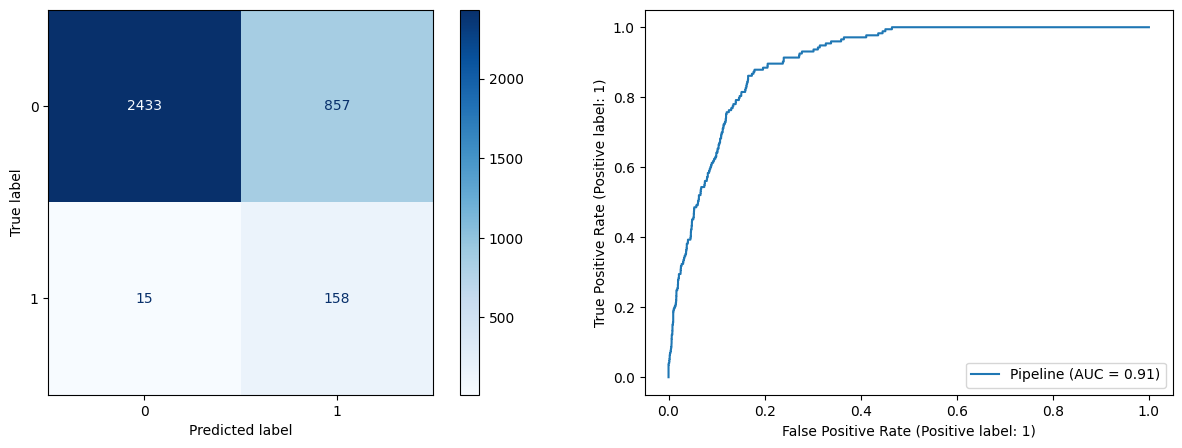

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Random Forest Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1411
           1       0.13      0.80      0.23        74

    accuracy                           0.73      1485
   macro avg       0.56      0.76      0.53      1485
weighted avg       0.94      0.73      0.81      1485



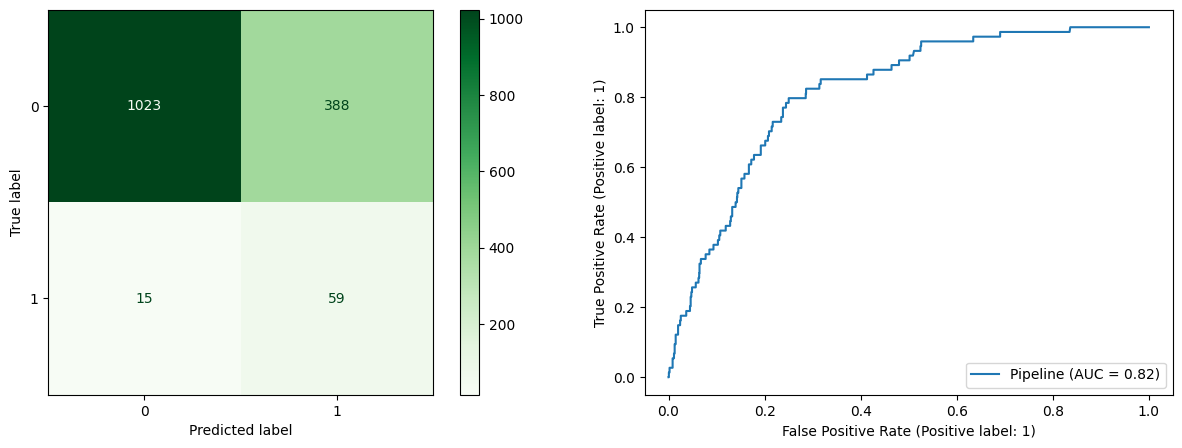

In [169]:
probability_report_matrix(tuned_ranforest_pipe, X_train, y_train, label='Tuned Random Forest Train Data',
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(tuned_ranforest_pipe, X_test, y_test, label='Tuned Random Forest Test Data',
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

- The accuracy is 73%.
- the model did better on the train data and worst on the test data.
- The false negatives are did not change, but the false positives increased. We want the model reduce the number of false negative.


# **XGBoost Model**

In [170]:
xgb = XGBClassifier(random_state=42, verbosity=0)

xgb_pipe = make_pipeline(processor, xgb)
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='const...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: XGBoost Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3290
           1       1.00      0.92      0.96       173

    accuracy                           1.00      3463
   macro avg       1.00      0.96      0.98      3463
weighted avg       1.00      1.00      1.00      3463



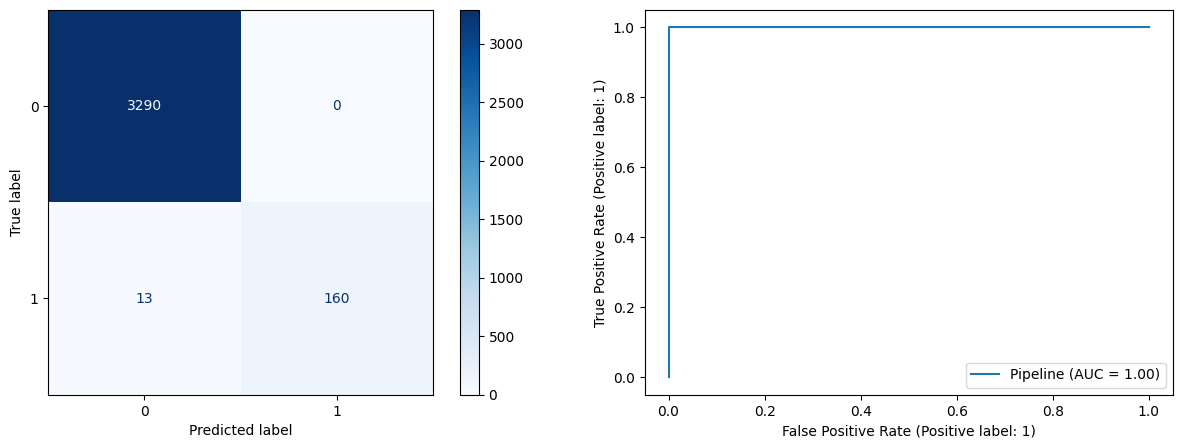

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: XGBoost Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1411
           1       0.22      0.09      0.13        74

    accuracy                           0.94      1485
   macro avg       0.59      0.54      0.55      1485
weighted avg       0.92      0.94      0.93      1485



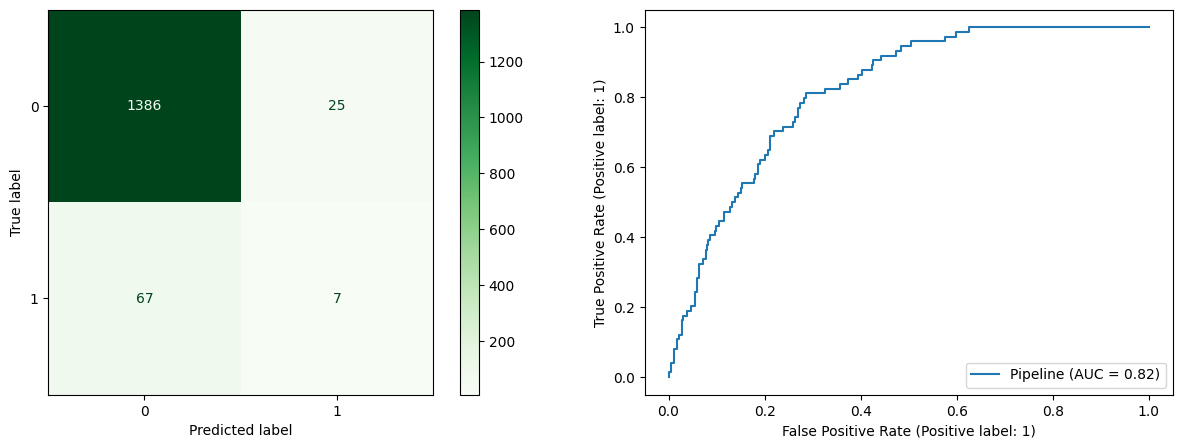

In [171]:
probability_report_matrix(xgb_pipe, X_train, y_train, label='XGBoost Train Data',
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(xgb_pipe, X_test, y_test, label='XGBoost Test Data',
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

- The model did better on the training data than the test data.
- 100% accuracy.
- The false negatives are nigher than the false positives.

##**XGBoost Tuning**

In [172]:
xgb_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                               

In [173]:
xgb_params = {'xgbclassifier__max_delta_step': range(0,6),
             'xgbclassifier__max_depth': range(3,11),
             'xgbclassifier__n_estimators': [10, 30, 50, 100]}

In [174]:
xgb_pipe_gs = GridSearchCV(xgb_pipe, xgb_params, scoring='f1')

xgb_pipe_gs.fit(X_train, y_train)
print('Best XGB Parameters:')
print(xgb_pipe_gs.best_params_)
best_xgb_pipe = xgb_pipe_gs.best_estimator_
print(f'Accuracy of best XGB model is: {best_xgb_pipe.score(X_test, y_test)}')

Best XGB Parameters:
{'xgbclassifier__max_delta_step': 1, 'xgbclassifier__max_depth': 8, 'xgbclassifier__n_estimators': 50}
Accuracy of best XGB model is: 0.94006734006734


## **Tuned XGBoost Model**

In [175]:
tuned_xgb = XGBClassifier(max_delta_step=1, max_depth=8, n_estimators=50, random_state=42, verbosity=0)

tuned_xgb_pipe = make_pipeline(processor, tuned_xgb)
tuned_xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='const...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=1,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned XGBoost Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3290
           1       1.00      0.84      0.92       173

    accuracy                           0.99      3463
   macro avg       1.00      0.92      0.96      3463
weighted avg       0.99      0.99      0.99      3463



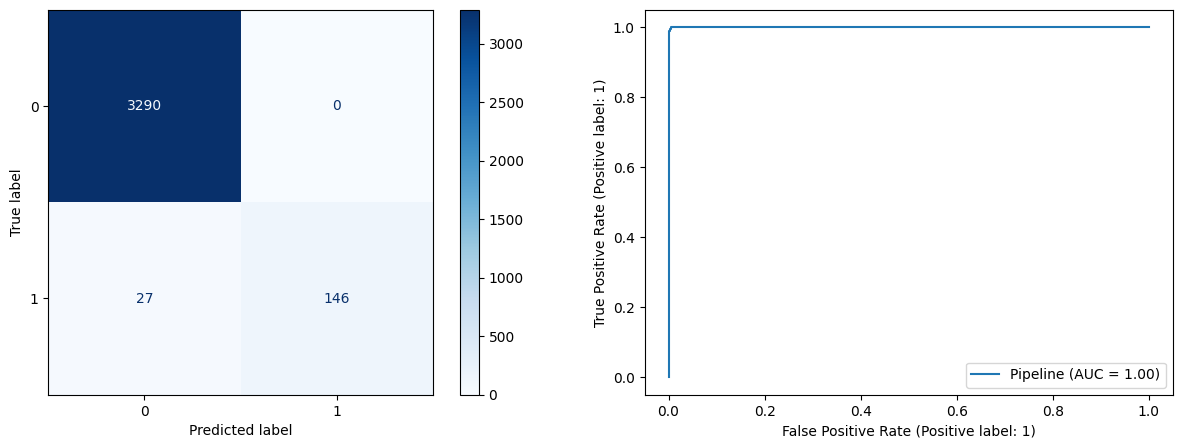

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned XGBoost Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1411
           1       0.20      0.07      0.10        74

    accuracy                           0.94      1485
   macro avg       0.58      0.53      0.54      1485
weighted avg       0.92      0.94      0.93      1485



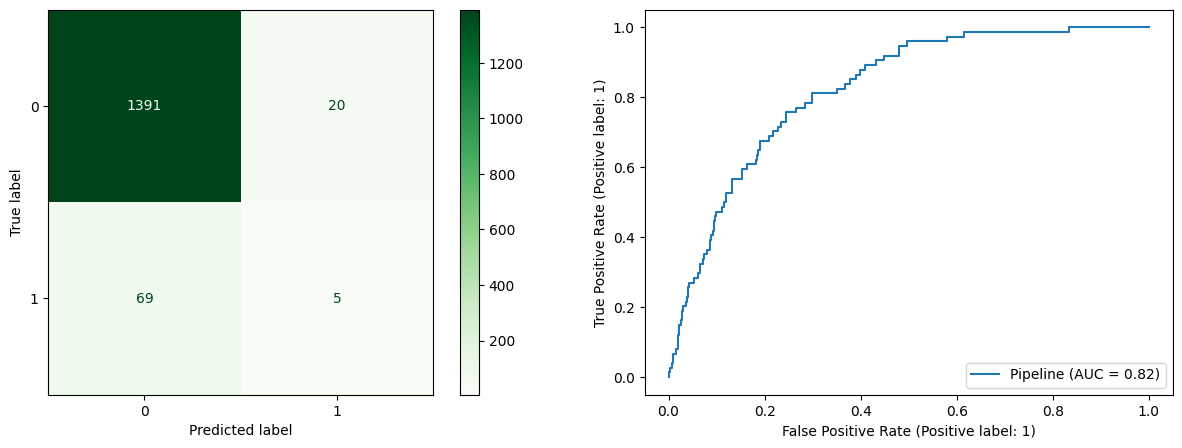

In [176]:
probability_report_matrix(tuned_xgb_pipe, X_train, y_train, label='Tuned XGBoost Train Data',
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(tuned_xgb_pipe, X_test, y_test, label='Tuned XGBoost Test Data',
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

- The train data scored higher in the recall and precision than it did on the test data.
- There are more false negative on the test. The false negative need to be reduced.

In [177]:
under_sampler = RandomUnderSampler()
xgb = XGBClassifier(random_state=42)

## Create a model pipeline with an UnderSampler in the pipeline
under_xgb_pipe = resample_pipeline(processor, under_sampler, xgb)
under_xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='const...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Under Sampling XGBoost Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      3290
           1       0.15      1.00      0.26       173

    accuracy                           0.72      3463
   macro avg       0.58      0.85      0.55      3463
weighted avg       0.96      0.72      0.80      3463



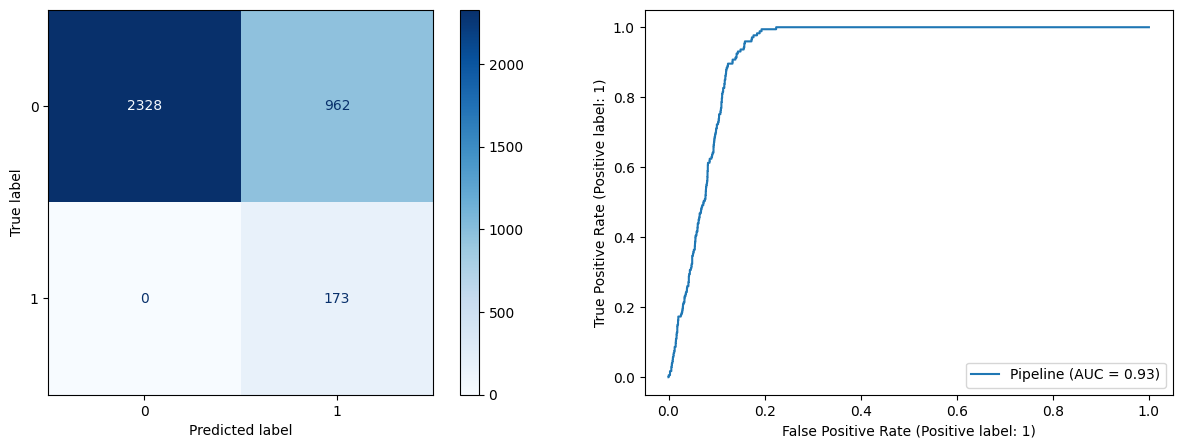

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Under Sampling XGBoost Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.70      0.82      1411
           1       0.12      0.77      0.21        74

    accuracy                           0.70      1485
   macro avg       0.55      0.74      0.51      1485
weighted avg       0.94      0.70      0.79      1485



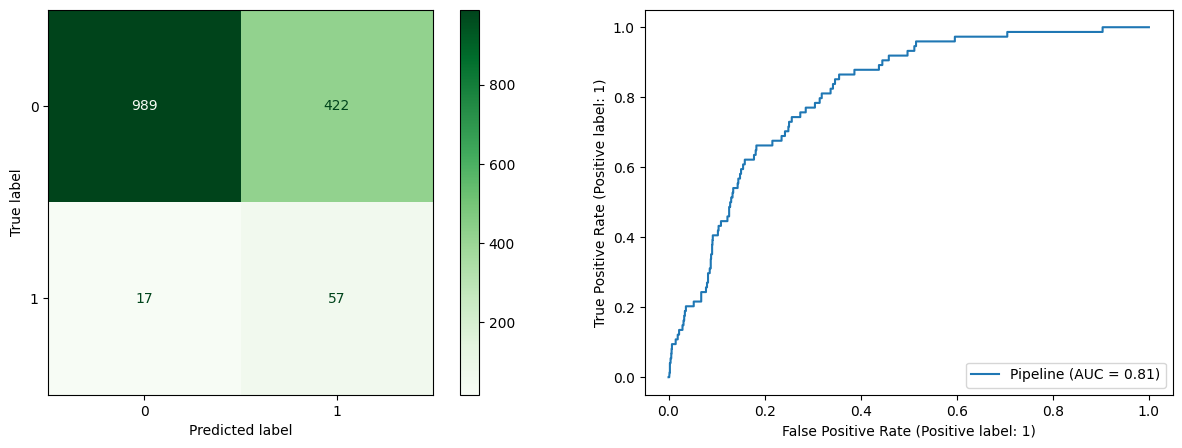

In [178]:
probability_report_matrix(under_xgb_pipe, X_train, y_train, label='Under Sampling XGBoost Train Data',
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(under_xgb_pipe, X_test, y_test, label='Under Sampling XGBoost Test Data',
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

- The training did better than the test on recall and precision.
- The number of false negatives has been reduced which is better for this business problem.

## **Tuned Under Sampling XGBoost**

In [179]:
under_xgb_pipe_gs = GridSearchCV(under_xgb_pipe, xgb_params, scoring='f1')

under_xgb_pipe_gs.fit(X_train, y_train)
print('Best XGB Parameters:')
print(under_xgb_pipe_gs.best_params_)
best_under_xgb_pipe = under_xgb_pipe_gs.best_estimator_
print(f'Accuracy of best XGB model is: {best_under_xgb_pipe.score(X_test, y_test)}')

Best XGB Parameters:
{'xgbclassifier__max_delta_step': 4, 'xgbclassifier__max_depth': 9, 'xgbclassifier__n_estimators': 30}
Accuracy of best XGB model is: 0.7131313131313132


In [180]:
tuned_under_sampler = RandomUnderSampler()
xgb = XGBClassifier(random_state=42)

## Create a model pipeline with an UnderSampler in the pipeline
tuned_under_xgb_pipe = resample_pipeline(processor, tuned_under_sampler, xgb)
tuned_under_xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='const...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Under Sampling XGBoost Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      3290
           1       0.18      1.00      0.30       173

    accuracy                           0.77      3463
   macro avg       0.59      0.88      0.58      3463
weighted avg       0.96      0.77      0.83      3463



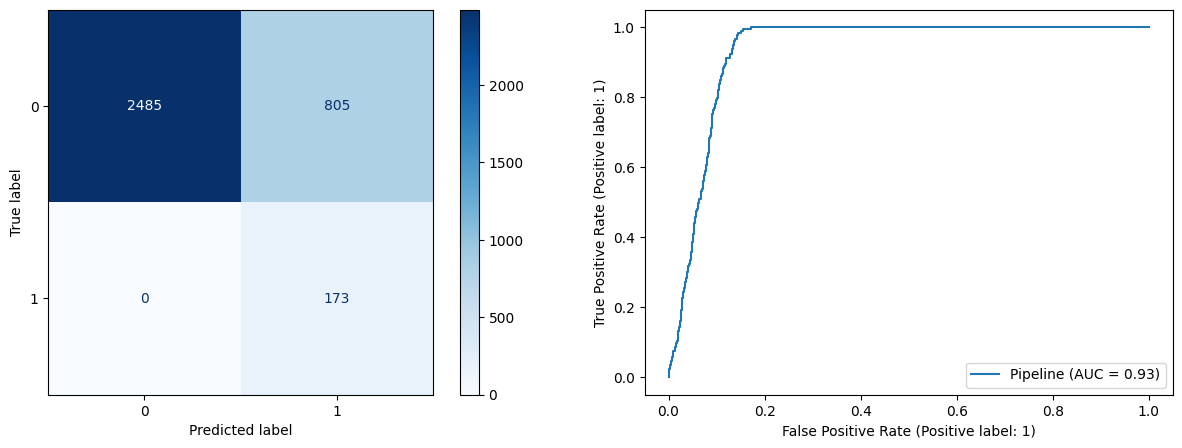

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Under Sampling XGBoost Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1411
           1       0.12      0.68      0.20        74

    accuracy                           0.73      1485
   macro avg       0.55      0.71      0.52      1485
weighted avg       0.93      0.73      0.81      1485



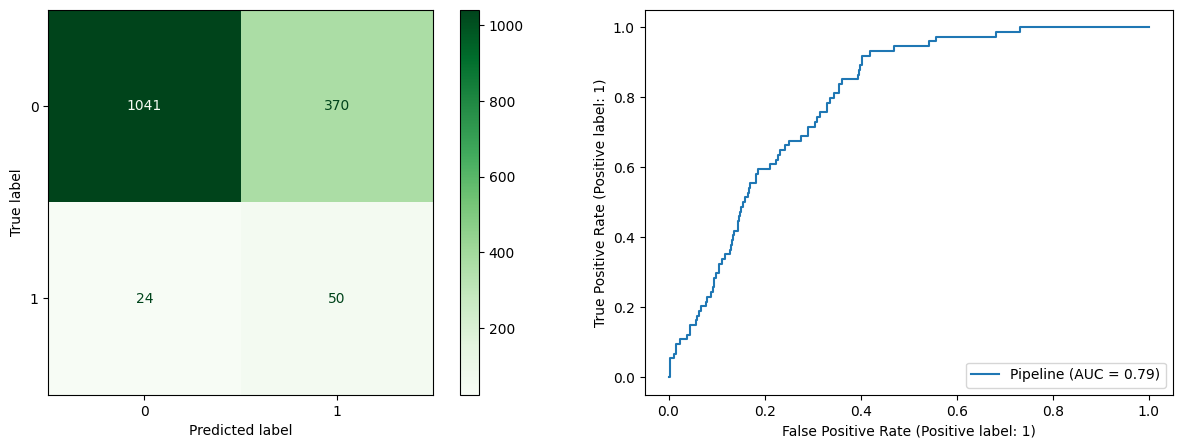

In [181]:
probability_report_matrix(tuned_under_xgb_pipe, X_train, y_train, label='Tuned Under Sampling XGBoost Train Data',
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(tuned_under_xgb_pipe, X_test, y_test, label='Tuned Under Sampling XGBoost Test Data',
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

- the train recall and is higher than the recall on the test data.
- precision is lower on the test and higher on the train.
- false negative are higher on the test

# **PCA**

In [182]:
df2 = df.copy()
df2.head()

,isfemale,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,1,5.432367,3.600048,formerly smoked,1
1,1,61.0,0,0,1,0,5.309307,NaN,never smoked,1
2,0,80.0,0,1,1,0,4.662684,3.481240,never smoked,1
3,1,49.0,0,0,1,1,5.143008,3.538057,smokes,1
4,1,79.0,1,0,1,0,5.159745,3.178054,never smoked,1


In [183]:
X2 = df2.drop(columns='stroke')
y2 = df2['stroke']

In [184]:
X2.shape

(4948, 9)

In [185]:
processed_df2 = processor.fit_transform(X2)
processed_df2.shape

(4948, 12)

In [186]:
processed_df2.shape[1]

12

In [187]:
pca = PCA()
pca.fit(processed_df2)

PCA()

## **Scree Plot**

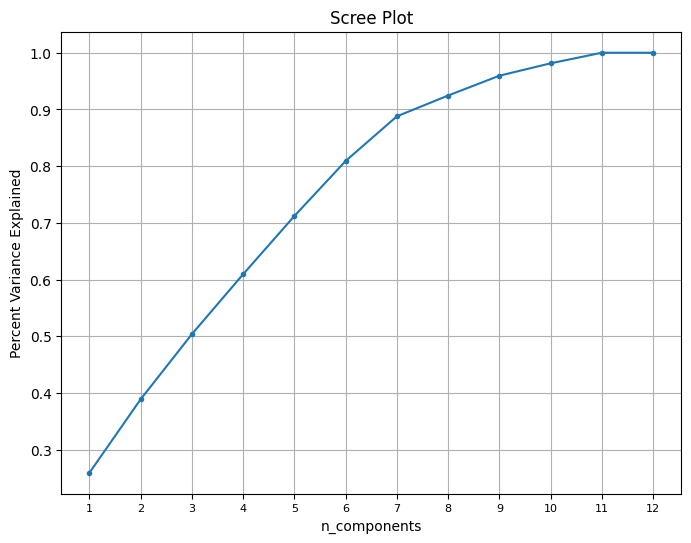

In [188]:
# plot the cumulative sum of the percentage of explained variance for each component and those before it.

fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(range(1, (processed_df2.shape[1] + 1)), pca.explained_variance_ratio_.cumsum(), marker= '.')
plt.xticks(ticks=range(1,(processed_df2.shape[1] + 1)), fontsize=8)

plt.xlabel('n_components')
plt.ylabel('Percent Variance Explained')
plt.title('Scree Plot')

plt.grid();

- from the Scree Plot we can see 7 n_compenents is a good point for PCA.

In [189]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, stratify=y, test_size=0.3, random_state=42)
pca7 = PCA(n_components=7)

## **KNN PCA**

In [190]:
knn = KNeighborsClassifier()

knn_pca_pipe = make_pipeline(processor, pca7, knn)
knn_pca_pipe.fit(X2_train, y2_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f17e0>)])),
                ('pca', PCA(n_components=7)),
                ('kneighborsclassifier', KNeighborsClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: PCA Random Forest Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3290
           1       0.46      0.03      0.06       173

    accuracy                           0.95      3463
   macro avg       0.71      0.52      0.52      3463
weighted avg       0.93      0.95      0.93      3463



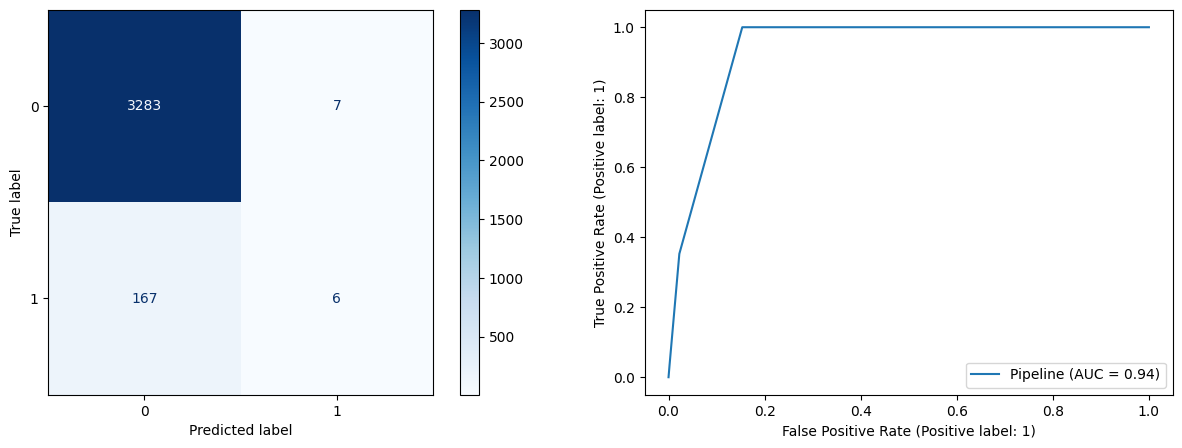

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: PCA Random Forest Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1411
           1       0.20      0.01      0.03        74

    accuracy                           0.95      1485
   macro avg       0.58      0.51      0.50      1485
weighted avg       0.91      0.95      0.93      1485



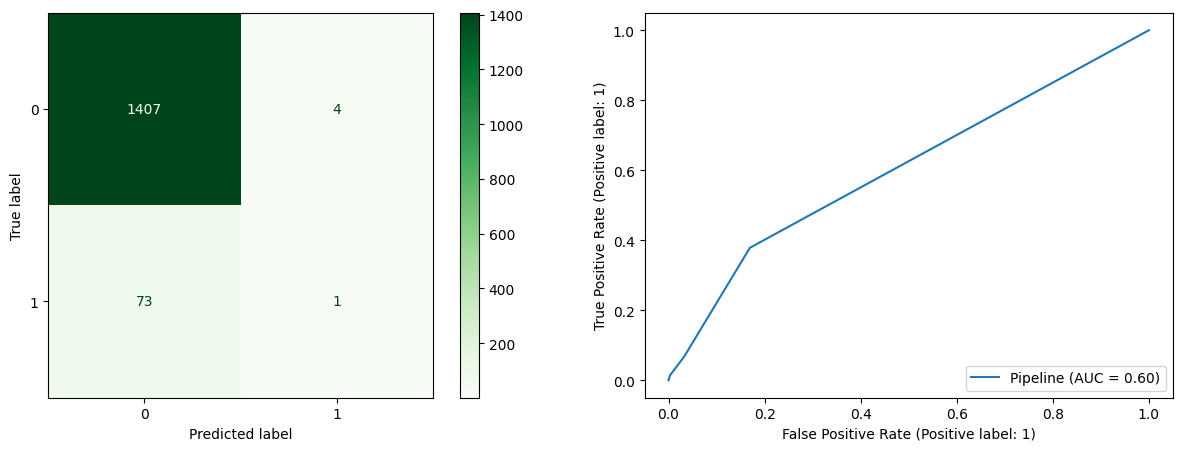

In [191]:
probability_report_matrix(knn_pca_pipe, X2_train, y2_train, label='PCA Random Forest Train Data',
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(knn_pca_pipe, X2_test, y2_test, label='PCA Random Forest Test Data',
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

- The recall for the train is higher than the test.
- Precision is also higher for the train and lower on the test.
- The false negative count is higher on the test set than it is for the false positive.

## **Tuned KNN PCA**

In [192]:
knn_params = {'kneighborsclassifier__n_neighbors': range(1,10),
              'kneighborsclassifier__p': range(1,5),
              'kneighborsclassifier__weights': ['distance','uniform']}

In [193]:
knn_pca_pipe_gs = GridSearchCV(knn_pca_pipe, knn_params, scoring='f1')

knn_pca_pipe_gs.fit(X2_train, y2_train)
print('Best KNN PCA Parameters:')
print(knn_pca_pipe_gs.best_params_)
best_knn_pca_pipe = knn_pca_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_knn_pca_pipe.score(X2_test, y2_test)}')

Best KNN PCA Parameters:
{'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__p': 3, 'kneighborsclassifier__weights': 'distance'}
Accuracy of best KNN model is: 0.9198653198653198


In [194]:
tuned_knn_pca = KNeighborsClassifier(n_neighbors=1, p=3, weights='distance')

tuned_knn_pca_pipe = make_pipeline(processor, pca7, tuned_knn_pca)
tuned_knn_pca_pipe.fit(X2_train, y2_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f17e0>)])),
                ('pca', PCA(n_components=7)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=1, p=3, weights='distance'))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned PCA KNN Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3290
           1       1.00      1.00      1.00       173

    accuracy                           1.00      3463
   macro avg       1.00      1.00      1.00      3463
weighted avg       1.00      1.00      1.00      3463



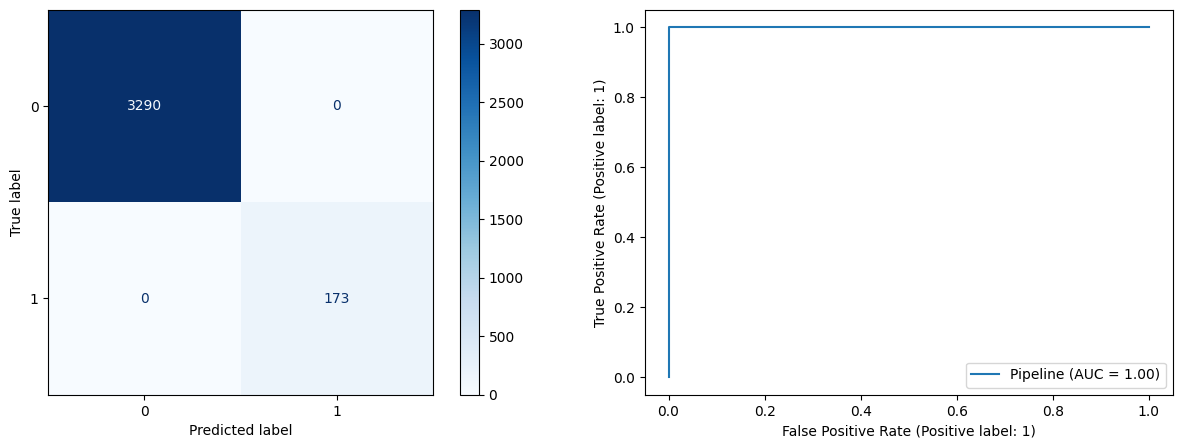

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned PCA KNN Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1411
           1       0.19      0.19      0.19        74

    accuracy                           0.92      1485
   macro avg       0.57      0.57      0.57      1485
weighted avg       0.92      0.92      0.92      1485



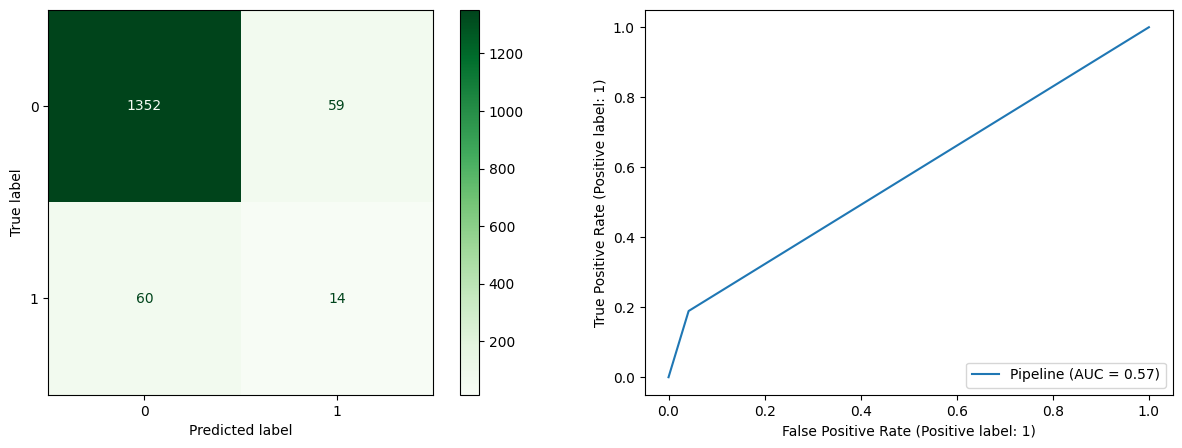

In [195]:
probability_report_matrix(tuned_knn_pca_pipe, X2_train, y2_train, label='Tuned PCA KNN Train Data',
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(tuned_knn_pca_pipe, X2_test, y2_test, label='Tuned PCA KNN Test Data',
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

- The train recall is significantly higher than the test.
- Precision is the same. It is significantly higher than the test.
- False negative is about equal to the false positive.

## **Under Sampling Tuned KNN PCA**

In [196]:
under_sampler = RandomUnderSampler()
knn = KNeighborsClassifier()

## Create a model pipeline with an UnderSampler in the pipeline
under_knn_pca_pipe = resample_pipeline(processor, under_sampler, pca, knn)
under_knn_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f17e0>)])),
                ('randomundersampler', RandomUnderSampler()), ('pca', PCA()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [197]:
under_knn_pca_pipe_gs = GridSearchCV(under_knn_pca_pipe, knn_params, scoring='f1')

under_knn_pca_pipe_gs.fit(X2_train, y2_train)
print('Best KNN Parameters:')
print(under_knn_pca_pipe_gs.best_params_)
best_under_knn_pca_pipe = under_knn_pca_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_under_knn_pca_pipe.score(X2_test, y2_test)}')

Best KNN Parameters:
{'kneighborsclassifier__n_neighbors': 8, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'uniform'}
Accuracy of best KNN model is: 0.7454545454545455


In [198]:
tuned_under_knn_cpa = KNeighborsClassifier(n_neighbors=8, p=4, weights='uniform')
under_sampler = RandomUnderSampler()

## Create a model pipeline with an UnderSampler in the pipeline
tuned_under_knn_pca_pipe = resample_pipeline(processor, under_sampler, pca, tuned_under_knn_cpa)
tuned_under_knn_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f36d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9287f17e0>)])),
                ('randomundersampler', RandomUnderSampler()), ('pca', PCA()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=8, p=4))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Under Sampling PCA KNN Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.71      0.82      3290
           1       0.12      0.77      0.21       173

    accuracy                           0.71      3463
   macro avg       0.55      0.74      0.52      3463
weighted avg       0.94      0.71      0.79      3463



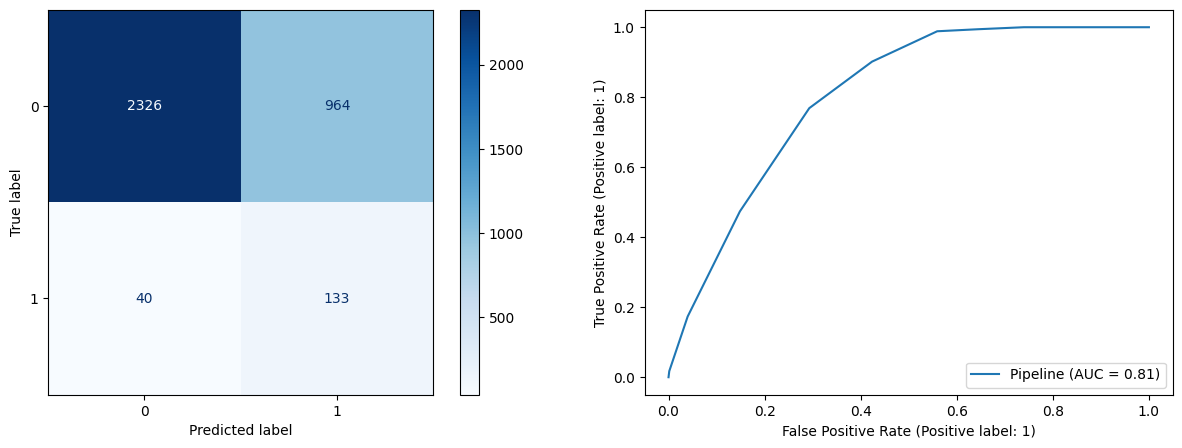

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Under Sampling PCA KNN Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.71      0.82      1411
           1       0.11      0.70      0.19        74

    accuracy                           0.71      1485
   macro avg       0.55      0.71      0.51      1485
weighted avg       0.94      0.71      0.79      1485



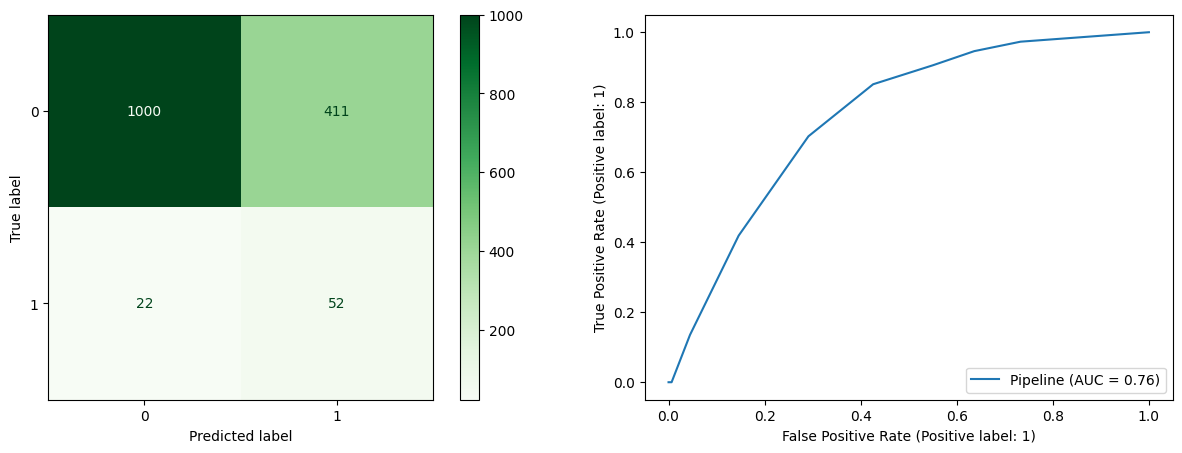

In [199]:
probability_report_matrix(tuned_under_knn_pca_pipe, X2_train, y2_train, label='Tuned Under Sampling PCA KNN Train Data',
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(tuned_under_knn_pca_pipe, X2_test, y2_test, label='Tuned Under Sampling PCA KNN Test Data',
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

- This model performed better on the train and slightly worse on the test for recall.
- Precision is the same for both train and test.
The model is 73% accurate.
The false negative are significantly lower than the false positive.


# **Best Overall Model Evaluation**

- The best model is the Tuned Random Forest. The Tuned Random Forest model is 73% accurate and has the highest recall percentage. The model can accurately predict strokes 80% of the time. The models also have the lowest false negatives. This means patients who are likely to have a stroke were not advised of the likelihood of a stroke when they should have been alerted. Reducing false negatives so the model accurately predicts strokes is the objection and what is best for this problem.

#**Recommendation**

The best model overall in predicting strokes is the Tuned Random Forest and I recommend this model for this business problem. Stakeholders would benefit from reducing the number of false negative. More of the doctor's patients will be flagged and doctors can provide information and lifestyle changes to prevent strokes. The trust between doctors and patients would strenghten and insurance companies would be paying less to hospital for emergency care. Hospital goings gain from providing patients ongoing preventive care.